# Symbolic controll - 2D case
The dynamic of the robot is given by the function:

The system describes the evolution of the state vector $\mathbf{x}(t) = (x_1(t), x_2(t))$ over time, using a discrete-time integration model:
## System Equations

The system evolution is defined by:

$$
x_1(t+1) = x_1(t) + \tau \cdot (v_x(t) + w_1(t)) \\
x_2(t+1) = x_2(t) + \tau \cdot (v_y(t) + w_2(t))
$$

## Constraints and Initialization

The initial position is:

$$
\mathbf{x}(0) = (x_1(0), x_2(0))
$$

The control input ($v$) and process noise ($w$) are bounded by:

$$
v_x(t), v_y(t) \in [-1, 1] \\
w_1(t), w_2(t) \in [-0.05, 0.05]
$$

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, deque
from tqdm import tqdm
import math
import datetime

# ----------------------------
# Grid & dynamics parameters
# ----------------------------
Nx1, Nx2 = 20,30
Nu1, Nu2 = 2,2
tau = 1.0

x1_range = (0.0, 10.0)
x2_range = (0.0, 10.0)


u1_range = (-1.0, 1.0)
u2_range = (-1.0, 1.0)

w1_bounds = (-0.05, 0.05)
w2_bounds = (-0.05, 0.05)

# Regions (same semantics as earlier)
R1 = ([4.0, 5.0], [8.5, 9.5])
R2 = ([8.5, 9.5], [2.0, 3.0])
R3 = ([2.0, 3.0], [0.5, 1.5])
R4 = ([3.0, 7.0], [3.0, 7.0])


In [47]:
# Automaton (same as 3d case)
AUTOMATON_STATES = ["q0", "q1", "q2", "q3", "q4"]
AUTOMATON_ACCEPTING = {"q3"}
AUTOMATON_TRANS = {
    ("q0", "None"): "q0",
    ("q0", "R1"): "q1",
    ("q0", "R2"): "q2",
    ("q0", "R3"): "q0",
    ("q0", "R4"): "q4",
    ("q1", "None"): "q1",
    ("q1", "R1"): "q1",
    ("q1", "R2"): "q4",
    ("q1", "R3"): "q3",
    ("q1", "R4"): "q4",
    ("q2", "None"): "q2",
    ("q2", "R1"): "q4",
    ("q2", "R2"): "q2",
    ("q2", "R3"): "q3",
    ("q2", "R4"): "q4",
    ("q3", "None"): "q3",
    ("q3", "R1"): "q3",
    ("q3", "R2"): "q3",
    ("q3", "R3"): "q3",
    ("q3", "R4"): "q3",
    ("q4", "None"): "q4",
    ("q4", "R1"): "q4",
    ("q4", "R2"): "q4",
    ("q4", "R3"): "q4",
    ("q4", "R4"): "q4",
}

# labels
LABELS = ["None", "R1", "R2", "R3", "R4"]



In [48]:
# Debug flag: set to True to run label diagnostics and exit early
DEBUG_LABELS = False

In [49]:
# ----------------------------
# Discretization grids & action sets
# ----------------------------
x1_bins = np.linspace(*x1_range, Nx1 + 1)
x2_bins = np.linspace(*x2_range, Nx2 + 1)

u1_vals = np.linspace(*u1_range, Nu1)
u2_vals = np.linspace(*u2_range, Nu2)
U_vals = [(u1_vals[i], u2_vals[j]) for i in range(Nu1) for j in range(Nu2)]

w_bounds = np.array([w1_bounds, w2_bounds])

# ----------------------------
# Grid boundary helpers
# ----------------------------
_X1_MAX = np.nextafter(x1_range[1], x1_range[0])
_X2_MAX = np.nextafter(x2_range[1], x2_range[0])


In [50]:
# ----------------------------
# Labeling helpers
# ----------------------------
def cell_in_region(cell, region):
    """Return True if the entire cell box is fully contained in the region box."""
    i, j = cell
    lo = (x1_bins[i], x2_bins[j])
    hi = (x1_bins[i + 1], x2_bins[j + 1])
    X, Y = region
    return (
        X[0] <= lo[0] and hi[0] <= X[1]
        and Y[0] <= lo[1] and hi[1] <= Y[1]
    )


In [51]:
def cell_overlaps_region(cell, region):
    """Overlap check retained for potential diagnostics; not used by labeling now."""
    i, j = cell
    lo = (x1_bins[i], x2_bins[j])
    hi = (x1_bins[i + 1], x2_bins[j + 1])
    X, Y = region # X = [xmin, xmax], Y = [ymin, ymax]

    def _ov(a0, a1, b0, b1):
        return max(a0, b0) < min(a1, b1)

    return _ov(lo[0], hi[0], X[0], X[1]) and _ov(lo[1], hi[1], Y[0], Y[1])


In [52]:
def L(cell):
    """Labeling function using strict full containment of the cell within regions."""
    x1, x2= cell
    if (
        R1[0][0] <= x1_bins[x1] <= R1[0][1] and R1[0][0] <= x1_bins[x1 + 1] <= R1[0][1]
        and R1[1][0] <= x2_bins[x2] <= R1[1][1] and R1[1][0] <= x2_bins[x2 + 1] <= R1[1][1]

    ):
        return "R1"
    elif (
        R2[0][0] <= x1_bins[x1] <= R2[0][1] and R2[0][0] <= x1_bins[x1 + 1] <= R2[0][1]
        and R2[1][0] <= x2_bins[x2] <= R2[1][1] and R2[1][0] <= x2_bins[x2 + 1] <= R2[1][1]
    ):
        return "R2"
    elif (
        R3[0][0] <= x1_bins[x1] <= R3[0][1] and R3[0][0] <= x1_bins[x1 + 1] <= R3[0][1]
        and R3[1][0] <= x2_bins[x2] <= R3[1][1] and R3[1][0] <= x2_bins[x2 + 1] <= R3[1][1]
    ):
        return "R3"
    elif (
        R4[0][0] <= x1_bins[x1] <= R4[0][1] and R4[0][0] <= x1_bins[x1 + 1] <= R4[0][1]
        and R4[1][0] <= x2_bins[x2] <= R4[1][1] and R4[1][0] <= x2_bins[x2 + 1] <= R4[1][1]
    ):
        return "R4"
    else:
        return "None"


In [53]:
# ----------------------------
# Label diagnostics (optional)
# ----------------------------
def debug_label_stats():
    """Enumerate all cells and compute labeling statistics and simple sanity checks."""
    counts = defaultdict(int)
    multi_overlap = 0
    samples = {"R1": [], "R2": [], "R3": [], "R4": []}
    for i in range(Nx1):
        for j in range(Nx2):
            cell = (i, j)
            overlaps = []
            for name, R in [("R4", R4), ("R1", R1), ("R2", R2), ("R3", R3)]:
                if cell_overlaps_region(cell, R):
                    overlaps.append(name)
            if len(overlaps) > 1:
                multi_overlap += 1
            lbl = L(cell)
            counts[lbl] += 1
            if lbl in samples and len(samples[lbl]) < 5:
                samples[lbl].append(cell)

    print("\n[Label Diagnostics]\nCounts:")
    for key in sorted(counts.keys()):
        print(f"  {key}: {counts[key]}")
    print(f"Multi-overlap cells (expected 0): {multi_overlap}")
    for region_name, cells in samples.items():
        print(f"Sample {region_name} cells: {cells}")
    assert counts["R1"] > 0 and counts["R2"] > 0 and counts["R3"] > 0 and counts["R4"] > 0, "Some regions have zero labeled cells; check overlap logic."
    assert multi_overlap == 0, "Found cells overlapping multiple regions; region definitions may intersect unexpectedly."
    print("Label diagnostics passed.")


In [54]:
def sample_label_tests():
    """Test representative continuous points to ensure q(.) and labeling agree with expectations."""
    test_points = [
        (4.5, 9.0, "R1"),
        (9.0, 2.5, "R2"),
        (2.5, 1.0, "R3"),
        (5.0, 5.0, "R4"),
        (0.5, 0.5, "None"),
    ]
    for x1v, x2v, expected in test_points:
        cell = q((x1v, x2v))
        lbl = L(cell)
        print(f"Point ({x1v:.2f},{x2v:.2f}) -> cell {cell} -> label {lbl} (expected {expected})")
        assert lbl == expected, f"Label mismatch: got {lbl}, expected {expected}"
    print("Sample label point tests passed.")


In [55]:
def _clamp_state_to_grid(x):
    x_clamped = np.array(x, dtype=float)
    x_clamped[0] = np.clip(x_clamped[0], x1_range[0], _X1_MAX)
    x_clamped[1] = np.clip(x_clamped[1], x2_range[0], _X2_MAX)
    return x_clamped


In [56]:
# ----------------------------
# General plotting helper
# ----------------------------
def plot_and_save(trajs, labels, fname_prefix="trajectory_plot", save=False):
    plt.figure(figsize=(6, 6))
    plt.xlim(x1_range)
    plt.ylim(x2_range)
    for R, label in [(R1, "R1"), (R2, "R2"), (R3, "R3"), (R4, "R4")]:
        xlo, xhi = R[0]
        ylo, yhi = R[1]
        plt.fill_between([xlo, xhi], [ylo, ylo], [yhi, yhi], alpha=0.25, label=label)
        plt.plot(
            [xlo, xhi, xhi, xlo, xlo], [ylo, ylo, yhi, yhi, ylo], "k-", linewidth=0.8
        )
    for traj, lab in zip(trajs, labels):
        pts = np.array(traj)
        if pts.size == 0:
            continue
        plt.plot(pts[:, 0], pts[:, 1], "-o", markersize=3, label=lab)
        plt.scatter(pts[0, 0], pts[0, 1], s=60, marker="s")
        plt.scatter(pts[-1, 0], pts[-1, 1], s=60, marker="*")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.title("Product-first: Multi-start BFS trajectories")
    plt.tight_layout()
    if save:
        fname = f"{fname_prefix}_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
        plt.savefig(fname, dpi=300)
        print(f"Plot saved to {fname}")
    plt.show()


In [57]:
# ----------------------------
# Symbolic plotting primitives
# ----------------------------
def draw_symbolic_state(state, color="blue", radius=0.12, ax=None):
    x_sym,_ = state
    pt = p(x_sym)
    x1, x2 = float(pt[0]), float(pt[1])
    if ax is None:
        ax = plt.gca()
    circ = plt.Circle((x1, x2), radius, facecolor="none", edgecolor=color, linewidth=0.8, zorder=5)
    ax.add_patch(circ)


In [58]:
def draw_progress(state1, state2, color="blue", ax=None, linewidth=1, linestyle="-"):
    if ax is None:
        ax = plt.gca()
    p1 = p(state1[0])
    p2 = p(state2[0])
    x1, y1 = float(p1[0]), float(p1[1])
    x2, y2 = float(p2[0]), float(p2[1])
    ax.plot([x1, x2], [y1, y2], color=color, linewidth=linewidth, linestyle=linestyle, zorder=4)


In [59]:
def build_bfs_policy_and_next(plan_path):
    """From BFS plan_path [(state, action_from_parent)], build policy and next_map."""
    policy = {}
    next_map = {}
    for idx in range(1, len(plan_path)):
        prev_state = plan_path[idx - 1][0]
        cur_state, act = plan_path[idx]
        if act is not None:
            policy[prev_state] = act
        next_map[prev_state] = cur_state
    return policy, next_map


In [60]:
def draw_trajectory_from(initial_state, product_transitions, policy, next_map, color="blue", ax=None, max_steps=500):
    if ax is None:
        ax = plt.gca()
    current_state = initial_state
    draw_symbolic_state(current_state, color=color, ax=ax)
    steps = 0
    while current_state[1] != "q3" :
        action = policy.get(current_state)
        nxt = next_map.get(current_state)
        if action is None or nxt is None:
            break
        succs = product_transitions.get((current_state, action), frozenset())
        if nxt not in succs:
            nxt = next(iter(succs)) if succs else None
            if nxt is None:
                break
        draw_progress(current_state, nxt, color=color, ax=ax)
        draw_symbolic_state(nxt, color=color, ax=ax)
        current_state = nxt
        steps += 1


In [61]:
# ----------------------------
# Symbolic plotting wrappers
# ----------------------------
def plot_symbolic_demo_one_start(initial_state, plan_path, product_transitions):
    policy, next_map = build_bfs_policy_and_next(plan_path)
    regions = [
        (R1, "R1", "#fdf7bb"),
        (R2, "R2", "#d8f2f9"),
        (R3, "R3", "#dbf5b9"),
        (R4, "R4", "#ffb99d"),
    ]
    plt.figure(figsize=(5, 5))
    plt.xlim(x1_range)
    plt.ylim(x2_range)
    plt.xlabel("x1")
    plt.ylabel("x2")
    for (region, label, color) in regions:
        x_range, y_range= region
        plt.fill_between(x_range, y_range[0], y_range[1], color=color, label=label)
        plt.plot(
            [x_range[0], x_range[1], x_range[1], x_range[0], x_range[0]],
            [y_range[0], y_range[0], y_range[1], y_range[1], y_range[0]],
            color="black", linewidth=0.8
)
    draw_trajectory_from(initial_state, product_transitions, policy, next_map, color="blue")
    plt.legend()
    plt.title("Symbolic BFS trajectory (one start)")
    plt.tight_layout()
    fname = f"symbolic_demo_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(fname, dpi=300)
    print(f"Symbolic plot saved to {fname}")
    plt.show()


In [62]:
def plot_symbolic_demo_multi_starts(starts, product_transitions, accepting, make_prod_init):
    regions = [
        (R1, "R1", "#fdf7bb"),
        (R2, "R2", "#d8f2f9"),
        (R3, "R3", "#dbf5b9"),
        (R4, "R4", "#ffb99d"),
    ]
    plt.figure(figsize=(5, 5))
    plt.xlim(x1_range)
    plt.ylim(x2_range)
    plt.xlabel("x1")
    plt.ylabel("x2")
    for (region, label, color) in regions:
        x_range, y_range = region
        plt.fill_between(x_range, y_range[0], y_range[1], color=color, label=label)
        plt.plot(
            [x_range[0], x_range[1], x_range[1], x_range[0], x_range[0]],
            [y_range[0], y_range[0], y_range[1], y_range[1], y_range[0]],
            color="black", linewidth=0.8
)
    colors = [f"C{i}" for i in range(10)]
    legend_handles = []
    for idx, x_init in enumerate(starts):
        prod_init, _ = make_prod_init(x_init)
        print(f"\n=== Multi-start demo: x0={x_init}, prod_init={prod_init} ===")
        plan_path = bfs_on_product(product_transitions, prod_init, accepting)
        if plan_path is None:
            print("No BFS plan found for this start; skipping.")
            continue
        policy, next_map = build_bfs_policy_and_next(plan_path)
        color = colors[idx % len(colors)]
        draw_trajectory_from(prod_init, product_transitions, policy, next_map, color=color)
        handle, = plt.plot([], [], color=color, label=f"start {idx + 1}")
        legend_handles.append(handle)
    if legend_handles:
        plt.legend(handles=legend_handles)
    else:
        plt.legend()
    plt.title("Symbolic BFS trajectories (multi-start)")
    plt.tight_layout()
    fname = f"symbolic_multi_demo_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(fname, dpi=300)
    print(f"Symbolic multi-start plot saved to {fname}")
    plt.show()


In [63]:
# ----------------------------
# Controller visualization helpers
# ----------------------------
def simulate_controller_trajectory(initial_state, prod_ctrl, product_transitions, max_steps=5000):
    visited = set()
    stack = [(initial_state, [initial_state])]
    while stack :
        current_state, path = stack.pop()
        if current_state[1] == "q3":
            return path
        if current_state in visited:
            continue
        visited.add(current_state)
        allowed = prod_ctrl.get(current_state, set())
        if not allowed:
            continue
        for action in allowed:
            succs = product_transitions.get((current_state, action), frozenset())
            for next_state in succs:
                if next_state not in visited:
                    stack.append((next_state, path + [next_state]))
    return []


In [64]:
def draw_controller_trajectory(trajectory, color="green", ax=None):
    if ax is None:
        ax = plt.gca()
    if not trajectory:
        return
    for idx, state in enumerate(trajectory):
        draw_symbolic_state(state, color=color, ax=ax)
        if idx > 0:
            draw_progress(trajectory[idx - 1], state, color=color, ax=ax)


In [65]:
def plot_controller_test_one_start(initial_state, prod_ctrl, product_transitions):
    trajectory = simulate_controller_trajectory(initial_state, prod_ctrl, product_transitions)
    if not trajectory:
        print("Controller test: No path to q3 found from initial state.")
        return
    print(f"Controller trajectory length: {len(trajectory)}, reached q3: {trajectory[-1][1] == 'q3'}")
    regions = [
        (R1, "R1", "#fdf7bb"),
        (R2, "R2", "#d8f2f9"),
        (R3, "R3", "#dbf5b9"),
        (R4, "R4", "#ffb99d"),
    ]
    plt.figure(figsize=(5, 5))
    plt.xlim(x1_range)
    plt.ylim(x2_range)
    plt.xlabel("x1")
    plt.ylabel("x2")
    for (region, label, color) in regions:
        x_range, y_range = region
        plt.fill_between(x_range, y_range[0], y_range[1], color=color, label=label)
        plt.plot(
            [x_range[0], x_range[1], x_range[1], x_range[0], x_range[0]],
            [y_range[0], y_range[0], y_range[1], y_range[1], y_range[0]],
            color="black", linewidth=0.8
)
    draw_controller_trajectory(trajectory, color="green")
    plt.legend()
    plt.title("Closed-loop controller test (no BFS)")
    plt.tight_layout()
    fname = f"controller_test_{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}.png"
    plt.savefig(fname, dpi=300)
    print(f"Controller test plot saved to {fname}")
    plt.show()


In [66]:
# ----------------------------
# Dynamics and abstraction interfaces
# ----------------------------
def q(x):
    i = np.clip(np.digitize(x[0], x1_bins) - 1, 0, Nx1 - 1)
    j = np.clip(np.digitize(x[1], x2_bins) - 1, 0, Nx2 - 1)
    return (int(i), int(j))


In [67]:
def p(cell):
    i, j = cell
    return np.array(
        (
            0.5 * (x1_bins[i] + x1_bins[i + 1]),
            0.5 * (x2_bins[j] + x2_bins[j + 1])
        )
    )


In [68]:
def f_cont(x, u, w, tau=tau):
    vx, vy = u
    wx, wy = w
    x1 = x[0] + tau * (vx + wx)
    x2 = x[1] + tau * (vy + wy)
    return np.array((x1, x2))


In [69]:
# ----------------------------
# Build symbolic transition table T
# ----------------------------
def build_transition_table():
    centers = {}
    half = {}
    for i in range(Nx1):
        for j in range(Nx2):
            centers[(i, j)] = p((i, j))
            half[(i, j)] = np.array(
                [
                    0.5 * (x1_bins[i + 1] - x1_bins[i]),
                    0.5 * (x2_bins[j + 1] - x2_bins[j]),
                ]
                )

    dw = np.array(
        [
            0.5 * (w1_bounds[1] - w1_bounds[0]),
            0.5 * (w2_bounds[1] - w2_bounds[0]),
        ]
    )

    T = {}
    cells = list(centers.keys())
    total = len(cells) * len(U_vals)
    with tqdm(
        total=total, desc="Building symbolic transition table", colour="cyan"
    ) as pbar:
        for cell in cells:
            c = centers[cell]
            dx = half[cell]
            for u_idx, u in enumerate(U_vals):
                x_nom = f_cont(c, u, np.zeros(2), tau)
                """Dx = np.array(
                    [[1, 0, tau * abs(u[0])], [0, 1, tau * abs(u[0])], [0, 0, 1]]
                )"""
                Dx = np.array(
                    [[1, 0], [0, 1]]
                )

                Dw = np.eye(2) * tau
                margin = Dx.dot(dx) + Dw.dot(dw)
                lower = x_nom - margin - 1e-9
                upper = x_nom + margin + 1e-9

                i_min = np.searchsorted(x1_bins, lower[0], side="right") - 1
                i_max = np.searchsorted(x1_bins, upper[0], side="left")
                j_min = np.searchsorted(x2_bins, lower[1], side="right") - 1
                j_max = np.searchsorted(x2_bins, upper[1], side="left")

                i_min, i_max = max(0, i_min), min(Nx1 - 1, max(i_min, i_max))
                j_min, j_max = max(0, j_min), min(Nx2 - 1, max(j_min, j_max))

                succs = set()
                for ii in range(i_min, i_max + 1):
                    for jj in range(j_min, j_max + 1):
                        lo = np.array([x1_bins[ii], x2_bins[jj]])
                        hi = np.array(
                            [x1_bins[ii + 1], x2_bins[jj + 1]]
                        )
                        if not (
                            hi[0] < lower[0]
                            or lo[0] > upper[0]
                            or hi[1] < lower[1]
                            or lo[1] > upper[1]
                        ):
                            succs.add((ii, jj))
                T[(cell, u_idx)] = frozenset(succs)
                pbar.update(1)
    return T


In [70]:
# ----------------------------
# Build product system P from T
# P: key ((cell,q), u_idx) -> set of (cell_next, q_next)
# ----------------------------
def build_product_system(T):
    P = {}
    total = len(T)
    with tqdm(total=total, desc="Building product system", colour="red") as pbar:
        for (cell, u_idx), succs in T.items():
            for qstate in AUTOMATON_STATES:
                # successor product states computed using successor cell labels
                sprod = set()
                for s in succs:
                    lbl_s = L(s)
                    q_next = AUTOMATON_TRANS[(qstate, lbl_s)]
                    sprod.add((s, q_next))
                P[((cell, qstate), u_idx)] = frozenset(sprod)
            pbar.update(1)
    return P


In [71]:
# ----------------------------
# Pre on product state space
# ----------------------------
def Pre_product(P, R):
    pre = set()
    prod_states = set(k[0] for k in P.keys())
    for ps in prod_states:
        for u_idx in range(len(U_vals)):
            succs = P.get((ps, u_idx), frozenset())
            if succs and all(s in R for s in succs):
                pre.add(ps)
                break
    return pre


In [72]:
# ----------------------------
# Product safety fixed-point
# ----------------------------
def compute_product_safety(P):
    """Compute set of product states whose successors remain in the safe region."""
    prod_states = set(k[0] for k in P.keys())
    Qs = {ps for ps in prod_states if L(ps[0]) != "R4" and ps[1] != "q4"}
    R = Qs.copy()
    with tqdm(desc="Product safety fixed-point", colour="magenta") as bar:
        while True:
            PreR = Pre_product(P, R)
            PreR &= Qs
            if PreR == R:
                break
            R = PreR
            bar.update(1)
    return R


In [73]:
# ----------------------------
# Product reachability fixed-point
# ----------------------------
def Pre_existential_target(P, safe_prod):
    pre = set()
    prod_states = set(k[0] for k in P.keys())
    for ps in prod_states:
        for u_idx in range(len(U_vals)):
            succs = P.get((ps, u_idx), frozenset())
            if not succs:
                continue
            if all(s in safe_prod for s in succs):
                pre.add(ps)
                break
    return pre


In [74]:
def compute_product_reachability(P, safe_prod):
    prod_states = set(k[0] for k in P.keys())
    Qf = {ps for ps in prod_states if L(ps[0]) == "R3" and ps[1] == "q3"}
    R = Qf.copy()
    with tqdm(desc="Product reachability fixed-point", colour="green") as bar:
        while True:
            PreR = Pre_existential_target(P, safe_prod) | Qf
            if PreR == R:
                print("Final Size of R:", len(R))
                break
            R = PreR
            bar.update(1)
    return R


In [75]:
def synthesize_product_controller(P, D):
    """Return a mapping prod_ctrl: product_state -> set of actions (u_idx)
    that keep all successors within safe_prod. Does NOT modify P.
    """
    prod_ctrl = defaultdict(set)
    for (ps, u_idx), succs in tqdm(P.items(), colour="yellow", desc="Synthesizing product controller"):
        if ps in D and succs and all(s in D for s in succs):
            prod_ctrl[ps].add(u_idx)
    return prod_ctrl


In [76]:
# ----------------------------
# BFS on product
# ----------------------------
def bfs_on_product(P, start_prod, accepting_set):
    print("\nStarting BFS on product from state:")
    print(start_prod)
    queue = deque([start_prod])
    parent = {start_prod: None}
    parent_u = {}
    visited = {start_prod}
    with tqdm(desc="BFS on product system", colour="white") as bar:
        while queue:
            cur = queue.popleft()
            bar.update(1)
            if cur in accepting_set:
                # reconstruct path: list of product states (node) with actions to reach next
                path = []
                node = cur
                while parent[node] is not None:
                    path.append((node, parent_u[node]))
                    node = parent[node]
                path.append((node, None))
                return list(reversed(path))
            for u_idx in range(len(U_vals)):
                succs = P.get((cur, u_idx), frozenset())
                for s in succs:
                    if s not in visited:
                        visited.add(s)
                        parent[s] = cur
                        parent_u[s] = u_idx
                        queue.append(s)
    return None

In [77]:
def _initialize_product_state(x):
    x = _clamp_state_to_grid(x)
    cell = q(x)
    lbl = L(cell)
    qstate = AUTOMATON_TRANS.get(("q0", lbl), "q0")
    return x, cell, lbl, qstate


In [78]:
# ----------------------------
# BFS-based disturbed simulation functions
# ----------------------------
_DW_HALF_WIDTH = 0.5 * (w_bounds[:, 1] - w_bounds[:, 0])
_DEFAULT_DISTURBANCE_SAMPLES = 7

def _sample_disturbance(rng):
    return rng.uniform(-_DW_HALF_WIDTH, _DW_HALF_WIDTH)


In [79]:
def simulate_bfs_disturbed_run(
    x0,
    prod_ctrl,
    product_transitions,
    num_disturbance_samples=_DEFAULT_DISTURBANCE_SAMPLES,
    max_expansions=5000,
    seed=None,
 ):
    """Forward BFS with disturbed propagation; returns a single disturbed trajectory."""
    rng = np.random.default_rng(seed)
    x_start, cell_start, lbl_start, q_start = _initialize_product_state(x0)
    start_state = (cell_start, q_start)
    if lbl_start == "R3" and q_start == "q3":
        return np.array([x_start.copy()]), True
    queue = deque([start_state])
    parents = {start_state: None}
    action_used = {start_state: None}
    state_repr = {start_state: x_start.copy()}
    goal_state = None
    expansions = 0
    while queue and expansions < max_expansions and goal_state is None:
        current = queue.popleft()
        expansions += 1
        x_current = state_repr[current]
        cell_cur, q_cur = current
        if L(cell_cur) == "R3" and q_cur == "q3":
            goal_state = current
            break
        allowed = prod_ctrl.get(current, set())
        if not allowed:
            continue
        for action in sorted(allowed):
            succs = product_transitions.get((current, action), frozenset())
            if not succs:
                continue
            accepted_successor = None
            accepted_state = None
            for _ in range(num_disturbance_samples):
                w = _sample_disturbance(rng)
                x_next = f_cont(x_current, U_vals[action], w)
                x_next = _clamp_state_to_grid(x_next)
                cell_next = q(x_next)
                lbl_next = L(cell_next)
                q_next = AUTOMATON_TRANS.get((q_cur, lbl_next), q_cur)
                prod_next = (cell_next, q_next)
                if prod_next in succs:
                    accepted_successor = prod_next
                    accepted_state = x_next
                    break
            if accepted_successor is None:
                continue
            if accepted_successor not in parents:
                parents[accepted_successor] = current
                action_used[accepted_successor] = action
                state_repr[accepted_successor] = accepted_state.copy()
                queue.append(accepted_successor)
            if L(accepted_successor[0]) == "R3" and accepted_successor[1] == "q3":
                goal_state = accepted_successor
                break
    if goal_state is None:
        return np.array([]), False
    path = []
    node = goal_state
    while node is not None:
        path.append(state_repr[node])
        node = parents[node]
    path.reverse()
    return np.array(path), True


In [80]:
# ----------------------------
# Ensemble runner and plotting utilities
# ----------------------------
def run_bfs_ensemble(
    x0,
    prod_ctrl,
    product_transitions,
    N=30,
    num_disturbance_samples=_DEFAULT_DISTURBANCE_SAMPLES,
    max_expansions=5000,
    seed=None,
 ):
    rng = np.random.default_rng(seed)
    trajectories = []
    success_flags = []
    for _ in range(N):
        run_seed = rng.integers(0, 2**32 - 1)
        traj, success = simulate_bfs_disturbed_run(
            x0,
            prod_ctrl,
            product_transitions,
            num_disturbance_samples=num_disturbance_samples,
            max_expansions=max_expansions,
            seed=run_seed,
        )
        trajectories.append(traj)
        success_flags.append(success)
    success_count = sum(success_flags)
    print(
        f"BFS ensemble summary: {success_count}/{N} runs reached R3 (success rate {success_count / max(1, N):.1%})."
    )
    return trajectories, success_flags


In [81]:
def plot_bfs_ensemble_trajectories(
    trajectories,
    regions=None,
    color="navy",
    alpha=0.18,
    linewidth=0.9,
    title="BFS disturbed closed-loop trajectories",
 ):
    if regions is None:
        regions = [
            (R1, "R1", "#fdf7bb"),
            (R2, "R2", "#d8f2f9"),
            (R3, "R3", "#dbf5b9"),
            (R4, "R4", "#ffb99d"),
        ]
    plt.figure(figsize=(6, 6))
    plt.xlim(x1_range)
    plt.ylim(x2_range)
    plt.xlabel("x1")
    plt.ylabel("x2")
    for (region, label, fill_color) in regions:
        xr, yr= region
        plt.fill_between(xr, yr[0], yr[1], color=fill_color, alpha=0.4, label=label, zorder=1)
    for traj in trajectories:
        if traj.size == 0:
            continue
        plt.plot(traj[:, 0], traj[:, 1], color=color, alpha=alpha, linewidth=linewidth, zorder=2)
    for (region, _, _) in regions:
        xr, yr = region
        plt.plot(
            [xr[0], xr[1], xr[1], xr[0], xr[0]],
            [yr[0], yr[0], yr[1], yr[1], yr[0]],
            color="black", linewidth=0.9, zorder=3
)
    plt.title(title)
    plt.tight_layout()
    plt.show()


In [82]:
# Building :
T = build_transition_table()
P = build_product_system(T)
safe_prod = compute_product_safety(P)
reach_prod = compute_product_reachability(P, safe_prod)
D = safe_prod & reach_prod
prod_ctrl = synthesize_product_controller(P, D)


Building product system: 100%|██████████| 2400/2400 [00:00<00:00, 7702.02it/s]
Product safety fixed-point: 0it [00:00, ?it/s]
Product reachability fixed-point: 1it [00:00, 25.91it/s]


Final Size of R: 2208


Synthesizing product controller: 100%|██████████| 12000/12000 [00:00<00:00, 601513.57it/s]


In [83]:
# Pruned product transitions restricted to safe & reachable domain (used for BFS/visualizations)
product_transitions = {
    (ps, u_idx): succs
    for (ps, u_idx), succs in P.items()
    if ps in D and succs and all(s in D for s in succs)
}

In [84]:
# ----------------------------
# Diagnostics gate
# ----------------------------
if DEBUG_LABELS:
    print("DEBUG_LABELS is True — running diagnostics and skipping the remaining pipeline.")
    debug_label_stats()
    sample_label_tests()
else:
    print("DEBUG_LABELS is False — proceeding with pipeline visualizations.")

DEBUG_LABELS is False — proceeding with pipeline visualizations.



=== Multi-start demo: x0=[0. 0.], prod_init=((0, 0), 'q0') ===

Starting BFS on product from state:
((0, 0), 'q0')


BFS on product system: 899it [00:00, 150046.93it/s]



=== Multi-start demo: x0=[9. 9.], prod_init=((18, 27), 'q0') ===

Starting BFS on product from state:
((18, 27), 'q0')


BFS on product system: 1034it [00:00, 129036.31it/s]



=== Multi-start demo: x0=[5.  9.5], prod_init=((10, 28), 'q0') ===

Starting BFS on product from state:
((10, 28), 'q0')


BFS on product system: 857it [00:00, 106403.37it/s]



=== Multi-start demo: x0=[8. 1.], prod_init=((16, 3), 'q0') ===

Starting BFS on product from state:
((16, 3), 'q0')


BFS on product system: 495it [00:00, 123781.11it/s]


Symbolic multi-start plot saved to symbolic_multi_demo_20251212_180849.png


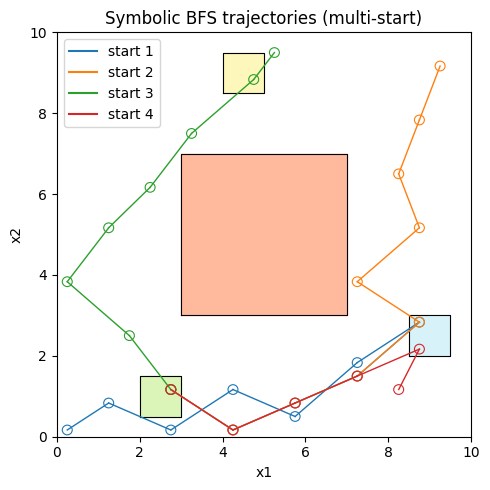

In [85]:
# ----------------------------
# Example execution: Symbolic multi-start BFS
# ----------------------------
if not DEBUG_LABELS:
    starts = [
        np.array((0.0, 0.0)),
        np.array((9.0, 9.0)),
        np.array((5.0, 9.5)),
        np.array((8.0, 1.0)),
    ]

    def make_prod_init(x_init):
        cell0 = q(x_init)
        lbl0 = L(cell0)
        q_init = ("q" + lbl0[1]) if lbl0.startswith("R") else "q0"
        return (cell0, q_init), q_init

    accepting = {ps for ps in D if L(ps[0]) == "R3" and ps[1] == "q3"}
    plot_symbolic_demo_multi_starts(starts, product_transitions, accepting, make_prod_init)



=== Controller test (no BFS) from: x0=[0. 0.], prod_init=((0, 0), 'q0') ===
Controller trajectory length: 350, reached q3: True
Controller test plot saved to controller_test_20251212_180852.png


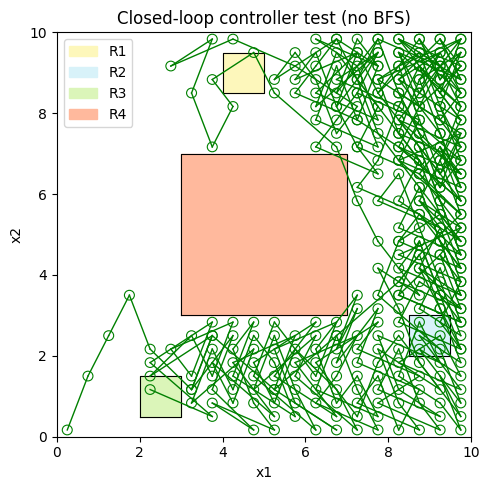

In [86]:
# ----------------------------
# Example execution: Closed-loop controller test
# ----------------------------
if not DEBUG_LABELS:
    test_start = starts[0]
    test_prod_init, _ = make_prod_init(test_start)
    print(f"\n=== Controller test (no BFS) from: x0={test_start}, prod_init={test_prod_init} ===")
    plot_controller_test_one_start(test_prod_init, prod_ctrl, product_transitions)


BFS ensemble summary: 25/25 runs reached R3 (success rate 100.0%).


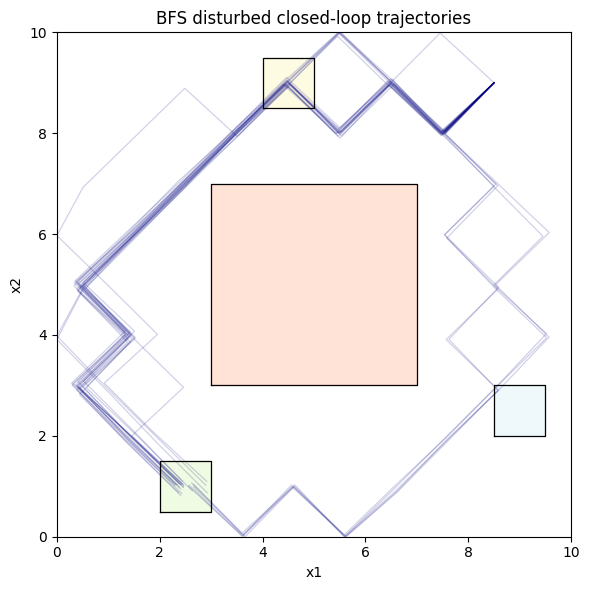

In [87]:
# ----------------------------
# Example execution: BFS disturbed ensemble
# ----------------------------
if not DEBUG_LABELS:
    ensemble_initial_state = np.array((8.5, 9.0))
    ensemble_runs = 25
    ensemble_num_disturbance_samples = 14
    ensemble_max_expansions = 5000
    ensemble_seed = 42
    bfs_trajs, bfs_success = run_bfs_ensemble(
        ensemble_initial_state,
        prod_ctrl,
        product_transitions,
        N=ensemble_runs,
        num_disturbance_samples=ensemble_num_disturbance_samples,
        max_expansions=ensemble_max_expansions,
        seed=ensemble_seed,
    )
    plot_bfs_ensemble_trajectories(bfs_trajs)



In [88]:
def save_trajectory_to_states_file(trajectory, filename="states.txt"):
    """
    Save a trajectory to states.txt format.
    Trajectory is a numpy array of shape (N, 2) containing (x, y) coordinates.
    Output format: i j v_lin
    """
    if trajectory.size == 0:
        print("Warning: Empty trajectory, cannot save to states.txt")
        return

    with open(filename, "w") as f:
        for idx in range(len(trajectory)):
            x, y = trajectory[idx]

            # Convert continuous coordinates to grid indices
            i = np.clip(np.digitize(x, x1_bins) - 1, 0, Nx1 - 1)
            j = np.clip(np.digitize(y, x2_bins) - 1, 0, Nx2 - 1)

            # Default linear velocity
            v_lin = 0.5

            # Write to file: i j v_lin
            f.write(f"{i} {j} {v_lin}\n")

    print(f"✓ Saved {len(trajectory)} states to {filename}")


# to create the file stetes.txt that contains the states where the robot moves
if not DEBUG_LABELS:
    # Use the first successful trajectory from the ensemble
    successful_traj = None
    for traj, success in zip(bfs_trajs, bfs_success):
        if success and traj.size > 0:
            successful_traj = traj
            break

    if successful_traj is not None:
        save_trajectory_to_states_file(successful_traj, "states.txt")
        print(f"Using trajectory with {len(successful_traj)} waypoints for PyBullet simulation")
    else:
        print("Warning: No successful trajectory found in ensemble!")
        # Create a simple fallback trajectory
        print("Creating simple fallback trajectory...")
        fallback_traj = np.array([
            [0.0, 0.0],
            [1.0, 0.0],
            [2.0, 0.0],
            [3.0, 0.0],
            [4.0, 1.0],
            [4.5, 2.0],
            [4.5, 3.0],
            [3.5, 4.0],
            [2.5, 4.0],
            [2.5, 3.0],
            [2.5, 2.0],
            [2.5, 1.0],
        ])
        save_trajectory_to_states_file(fallback_traj, "states.txt")

✓ Saved 13 states to states.txt
Using trajectory with 13 waypoints for PyBullet simulation


In [89]:
!pip install pybullet

In [90]:
###### Pybullet simulation setup ######
# Pybullet simulation

import pybullet as p
import pybullet_data
import math
import numpy as np
import time
import os

# -----------------------------------------
# Configuration from discretization
# -----------------------------------------
Nx1, Nx2 = 20 , 20
x1_range = (0.0, 10.0)
x2_range = (0.0, 10.0)

x1_bins = np.linspace(x1_range[0], x1_range[1], Nx1 + 1)
x2_bins = np.linspace(x2_range[0], x2_range[1], Nx2 + 1)

def p_cell(cell):
    i, j = cell
    i = min(max(int(i), 0), Nx1 - 1)
    j = min(max(int(j), 0), Nx2 - 1)
    x = 0.5 * (x1_bins[i] + x1_bins[i + 1])
    y = 0.5 * (x2_bins[j] + x2_bins[j + 1])
    return x, y



# -----------------------------------------
# Initialize PyBullet
# -----------------------------------------
p.connect(p.GUI)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)

# Ground plane
plane = p.loadURDF("plane.urdf")

texture_path = os.path.abspath("floor.png")
if os.path.exists(texture_path):
    try:
        texture_id = p.loadTexture(texture_path)
        p.changeVisualShape(plane, -1, textureUniqueId=texture_id)
    except:
        print("Warning: Could not load texture, using plain color")
        p.changeVisualShape(plane, -1, rgbaColor=[0.8, 0.8, 0.8, 1.0])
else:
    print("Warning: floor.png not found, using plain color")
    p.changeVisualShape(plane, -1, rgbaColor=[0.8, 0.8, 0.8, 1.0])

p.resetDebugVisualizerCamera(
    cameraDistance=10,
    cameraYaw=0,
    cameraPitch=-50,
    cameraTargetPosition=[5, 5, 0]
)

# Set gravity
p.setGravity(0, 0, -9.81)

# -----------------------------------------
# Region coloring and creation
# -----------------------------------------
def hex_to_rgba(hex_color, alpha=1.0):
    hex_color = hex_color.lstrip("#")
    r = int(hex_color[0:2], 16) / 255
    g = int(hex_color[2:4], 16) / 255
    b = int(hex_color[4:6], 16) / 255
    return [r, g, b, alpha]

def create_region_box(range_x, range_y, name, hex_color):
    x_min, x_max = range_x
    y_min, y_max = range_y
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2
    size_x = (x_max - x_min) / 2 + 0.3 # i addede small margin to avoid gaps
    size_y = (y_max - y_min) / 2 + 0.3 # i addede small margin to avoid gaps
    size_z = 0.05
    rgba = hex_to_rgba(hex_color)
    col = p.createCollisionShape(p.GEOM_BOX, halfExtents=[size_x, size_y, size_z])
    vis = p.createVisualShape(p.GEOM_BOX, halfExtents=[size_x, size_y, size_z], rgbaColor=rgba)
    p.createMultiBody(baseMass=0, baseCollisionShapeIndex=col, baseVisualShapeIndex=vis, basePosition=[cx, cy, 0])

R1 = ([4.0, 5.0], [8.5, 9.5])
R2 = ([8.5, 9.5], [2.0, 3.0])
R3 = ([2.0, 3.0], [0.5, 1.5])
R4 = ([3.0, 7.0], [3.0, 7.0])

regions = [
    (R1, "R1", "#fdf7bb"),
    (R2, "R2", "#d8f2f9"),
    (R3, "R3", "#dbf5b9"),
    (R4, "R4", "#ffb99d"),
]

for (rng, name, col) in regions:
    create_region_box(rng[0], rng[1], name, col)



# -----------------------------------------
# Create Walls
# -----------------------------------------
def create_wall(x, y, length, thickness, height):
    col = p.createCollisionShape(
        p.GEOM_BOX,
        halfExtents=[length/2, thickness/2, height/2]
    )

    vis = p.createVisualShape(
        p.GEOM_BOX,
        halfExtents=[length/2, thickness/2, height/2],
        rgbaColor=[0.1, 0.1, 0.1, 1]   # dark grey border
    )
    p.createMultiBody(
        baseMass=0,
        baseCollisionShapeIndex=col,
        baseVisualShapeIndex=vis,
        basePosition=[x, y, height/2]
    )

# ----- Map parameters -----
MAP_MIN = -0.5
MAP_MAX = 10.5
WALL_THICK = 0.05
WALL_HEIGHT = 0.3

# ----- Four walls around the map -----

# Top wall
create_wall(
    x=(MAP_MIN + MAP_MAX)/2,
    y=MAP_MAX + WALL_THICK/2,
    length=(MAP_MAX - MAP_MIN),
    thickness=WALL_THICK,
    height=WALL_HEIGHT
)

# Bottom wall
create_wall(
    x=(MAP_MIN + MAP_MAX)/2,
    y=MAP_MIN - WALL_THICK/2,
    length=(MAP_MAX - MAP_MIN),
    thickness=WALL_THICK,
    height=WALL_HEIGHT
)

# Left wall
create_wall(
    x=MAP_MIN - WALL_THICK/2,
    y=(MAP_MIN + MAP_MAX)/2,
    length=WALL_THICK,
    thickness=(MAP_MAX - MAP_MIN),
    height=WALL_HEIGHT
)

# Right wall
create_wall(
    x=MAP_MAX + WALL_THICK/2,
    y=(MAP_MIN + MAP_MAX)/2,
    length=WALL_THICK,
    thickness=(MAP_MAX - MAP_MIN),
    height=WALL_HEIGHT
)

print("Border walls added!")


# -----------------------------------------
# Load URDF model as the "robot"
# -----------------------------------------
SPOON_URDF_PATH = "husky/husky.urdf"
height = 0
robot = p.loadURDF(SPOON_URDF_PATH, basePosition=[0, 0, 0.0])


# -----------------------------------------
# Load states from the text file
# -----------------------------------------
states = []
states_path = "states.txt"

with open(states_path) as f:
    for line in f:
        s = line.strip()
        if not s:
            continue
        parts = s.split()
        if len(parts) < 3:
            continue
        i = int(float(parts[0]))
        j = int(float(parts[1]))
        v_lin = float(parts[3]) if len(parts) >= 4 else 0.0
        v_ang = float(parts[4]) if len(parts) >= 5 else 0.0
        x, y  = p_cell((i, j))
        states.append((x, y, v_lin))

if len(states) == 0:
    raise RuntimeError("No states loaded from states.txt")

print(f"Loaded {len(states)} states.")


# -----------------------------------------
# Animation parameters
# -----------------------------------------
FPS = 60
dt = 1.0 / FPS
RADIAL_SPEED = 2  # rad/s
MOVE_DURATION = 1.0  # seconds for straight motion

# Initialize robot to first state
x0, y0, _ = states[0]
p.resetBasePositionAndOrientation(robot, [x0, y0, 0.0], p.getQuaternionFromEuler([0, 0, 0]))
p.stepSimulation()

# -----------------------------------------
# Animation loop
# -----------------------------------------
for idx in range(len(states) - 1):
    x1, y1, v1 = states[idx]
    x2, y2, v2 = states[idx + 1]

    # Compute direction of movement
    dx = x2 - x1
    dy = y2 - y1

    # Get current angle of the robot (from previous frame)
    (pos, orn) = p.getBasePositionAndOrientation(robot)
    euler = p.getEulerFromQuaternion(orn)
    current_angle = euler[2]


    # -------- TRANSLATION PHASE --------
    frames_move = int(MOVE_DURATION * FPS)

    for frame in range(frames_move):
        alpha = frame / (frames_move - 1)
        x = x1 + alpha * dx
        y = y1 + alpha * dy

        quat = p.getQuaternionFromEuler([0, 0, 0])
        p.resetBasePositionAndOrientation(robot, [x, y, height], quat)

        p.stepSimulation()
        time.sleep(dt)

print("Animation finished. Window will remain open.")

# -----------------------------------------
# Keep window open
# -----------------------------------------
while True:
    p.stepSimulation()
    time.sleep(0.1)

Border walls added!
Loaded 13 states.


error: Not connected to physics server.